In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata


AnnData object with n_obs × n_vars = 19463 × 2763
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels', 'B', 'CD8+ T', 'DC', 'NK', 'Resting T', 'Tfh', 'Th2', 'Treg', 'gd T', 'cell_type', 'marker_ct'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SYMBOL', 'MT_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'log1p', 'mod', 'neighbors', 'pca', 'umap'
    obsm: 'MT', 'X_pca', 'X_umap', 'means_cell_abundance_w_sf', 'q05_cell_

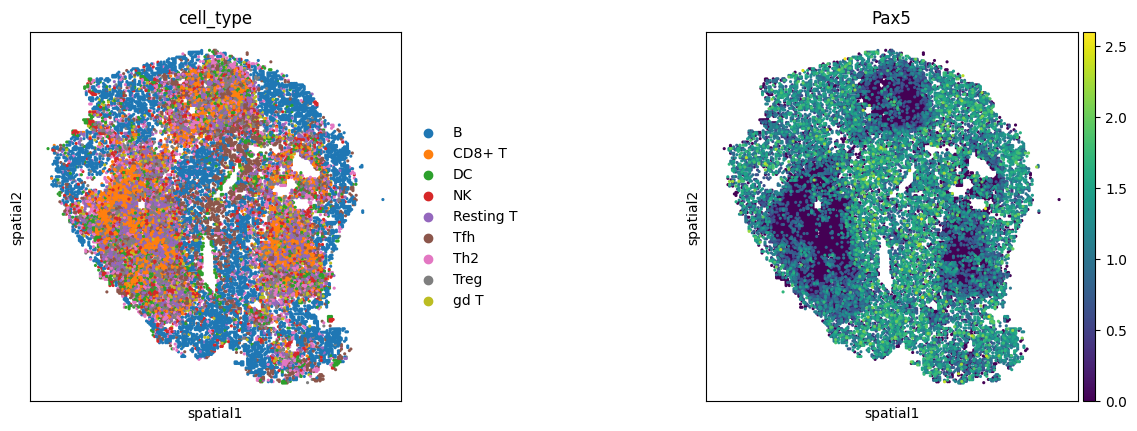

cell_type
B            5422
Resting T    2629
CD8+ T       2386
Tfh          2151
Treg         1987
Th2          1633
NK           1292
DC           1249
gd T          714
Name: count, dtype: int64

In [4]:
sc.pl.spatial(adata, color=['cell_type', 'Pax5'], spot_size=20)
adata.obs['cell_type'].value_counts()

In [5]:
import sys
sys.path.append('../../src/')

In [6]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

1 package does not meet CellOracle requirement.
 Your jupyter version is not_found. Please install jupyter


### Get GRN

In [7]:
adata

AnnData object with n_obs × n_vars = 19463 × 2763
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels', 'B', 'CD8+ T', 'DC', 'NK', 'Resting T', 'Tfh', 'Th2', 'Treg', 'gd T', 'cell_type', 'marker_ct'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SYMBOL', 'MT_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'log1p', 'mod', 'neighbors', 'pca', 'umap'
    obsm: 'MT', 'X_pca', 'X_umap', 'means_cell_abundance_w_sf', 'q05_cell_

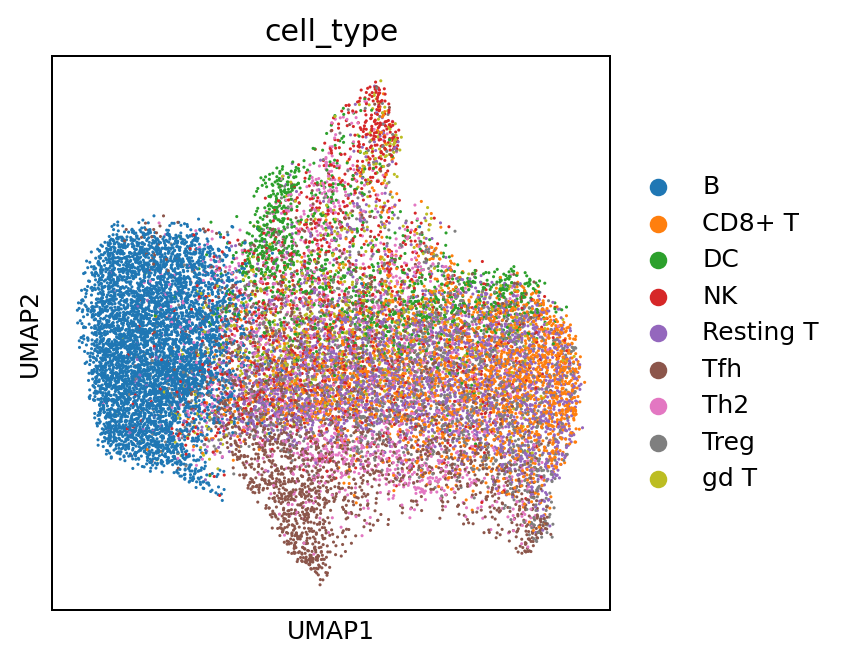

In [8]:
sc.pl.umap(adata, color='cell_type')

In [9]:
# from spaceoracle.oracles import BaseTravLR

# pcs = BaseTravLR.perform_PCA(adata)
# BaseTravLR.impute_clusterwise(adata)

In [10]:
adata.layers['imputed_count'] = adata.layers['normalized_count'].toarray()
adata.layers['imputed_count'] = adata.layers['imputed_count'].astype(np.float64)

In [11]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [12]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [13]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 9/9 [56:08<00:00, 374.26s/it]


CPU times: user 49min 11s, sys: 12.3 s, total: 49min 23s
Wall time: 56min 10s


In [14]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
import pickle

with open('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD_subsampled_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [16]:
links.to_hdf5(file_path="/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD_subsampled.celloracle.links")
oracle.to_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD_subsampled.celloracle.oracle")

### Perturb

In [7]:
oracle = co.load_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD_subsampled.celloracle.oracle")
links = co.load_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD_subsampled.celloracle.links")

In [8]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
oracle.cluster_column_name

'cell_type'

In [ ]:
# oracle.adata.uns['draw_graph'] = {}
# oracle.adata.uns['draw_graph']["params"] = {}
# oracle.adata.uns['draw_graph']["params"]["layout"] = 'X_umap'

# oracle.adata.obs['draw_graph_X_umap'] = adata.obsm['X_umap']

In [10]:
goi='Pax5'

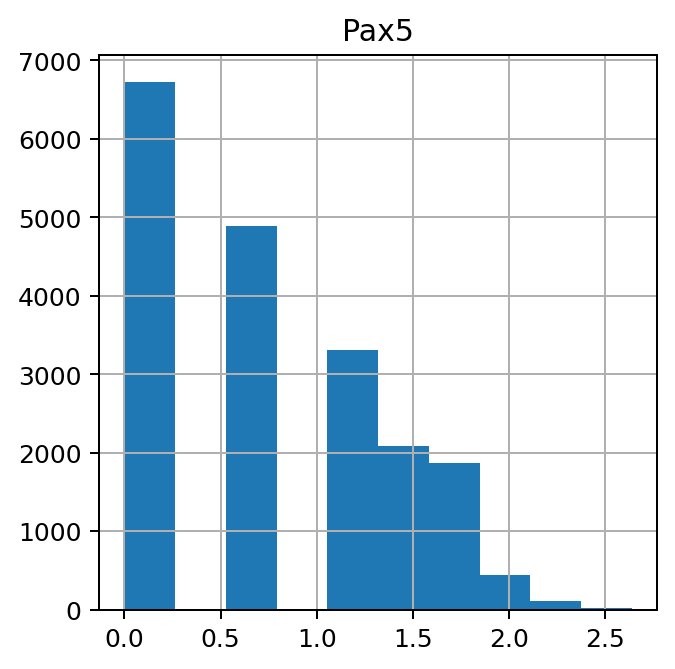

In [11]:
sc.get.obs_df(oracle.adata, keys=[goi], layer="normalized_count").hist()
plt.show()

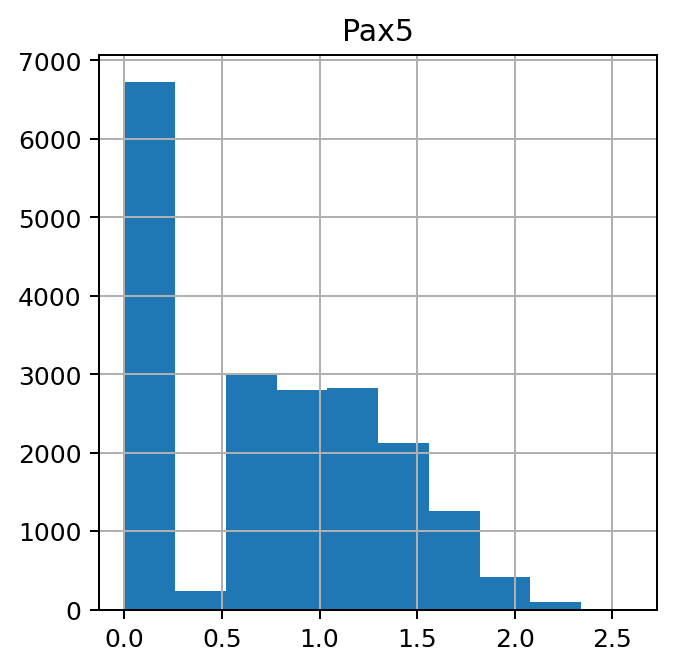

In [12]:
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [13]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

: 

: 

In [ ]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

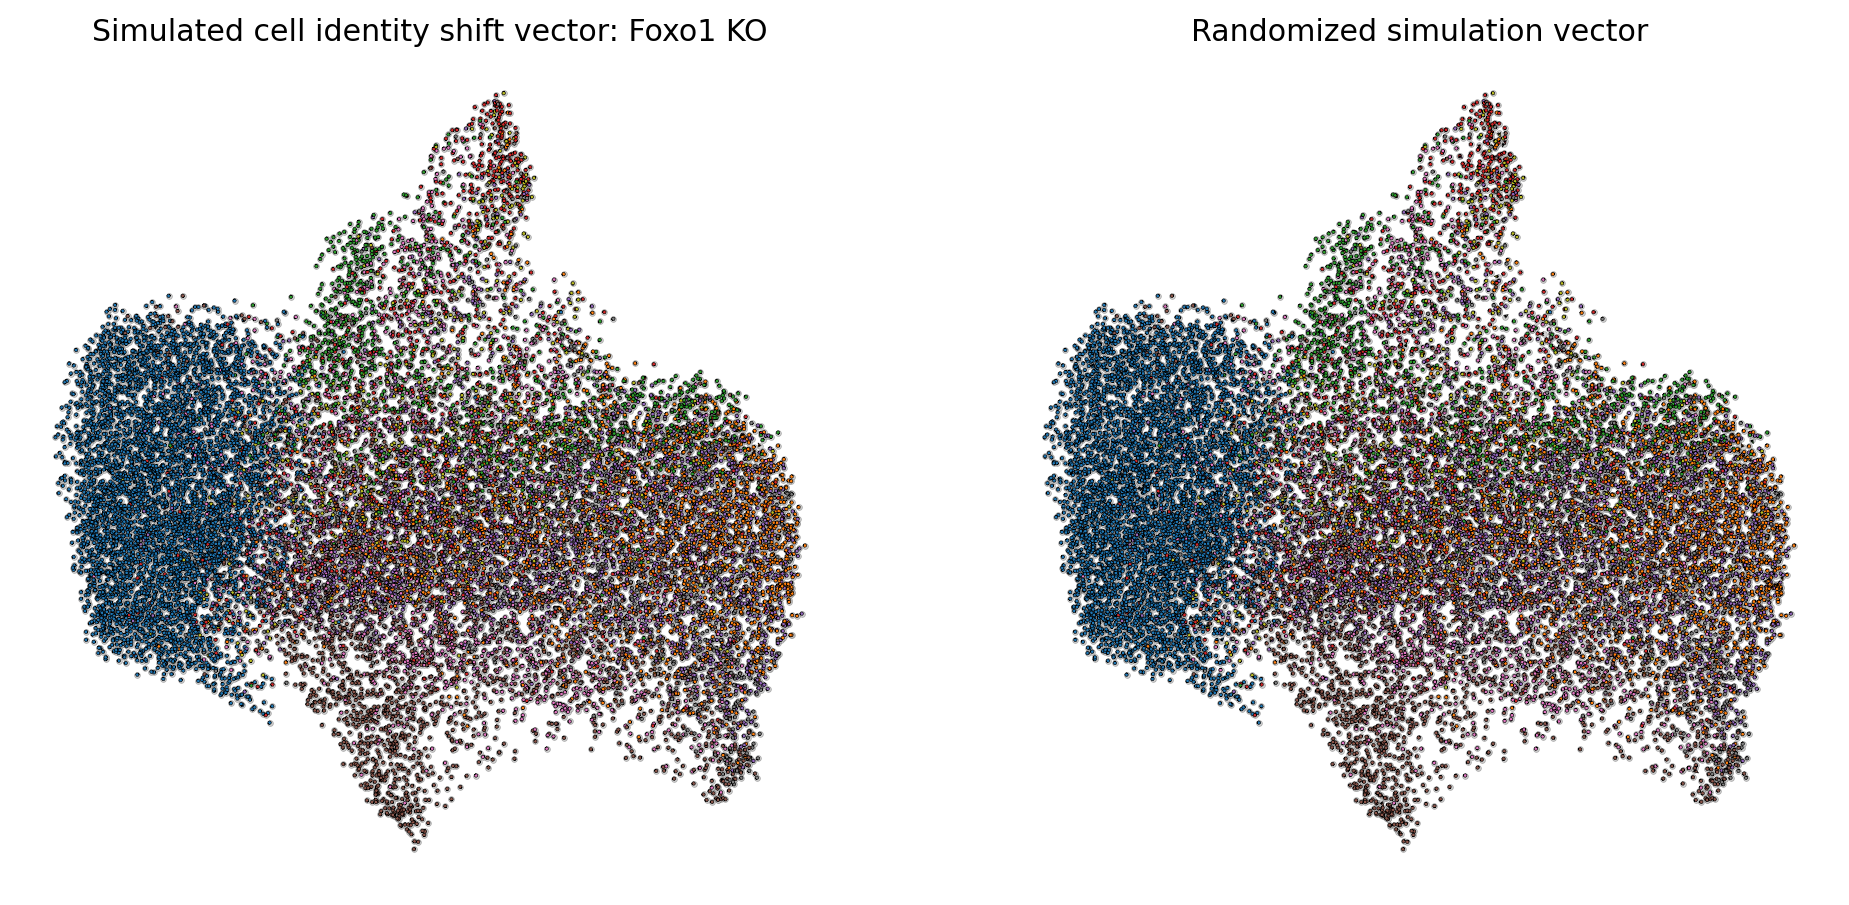

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 20
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

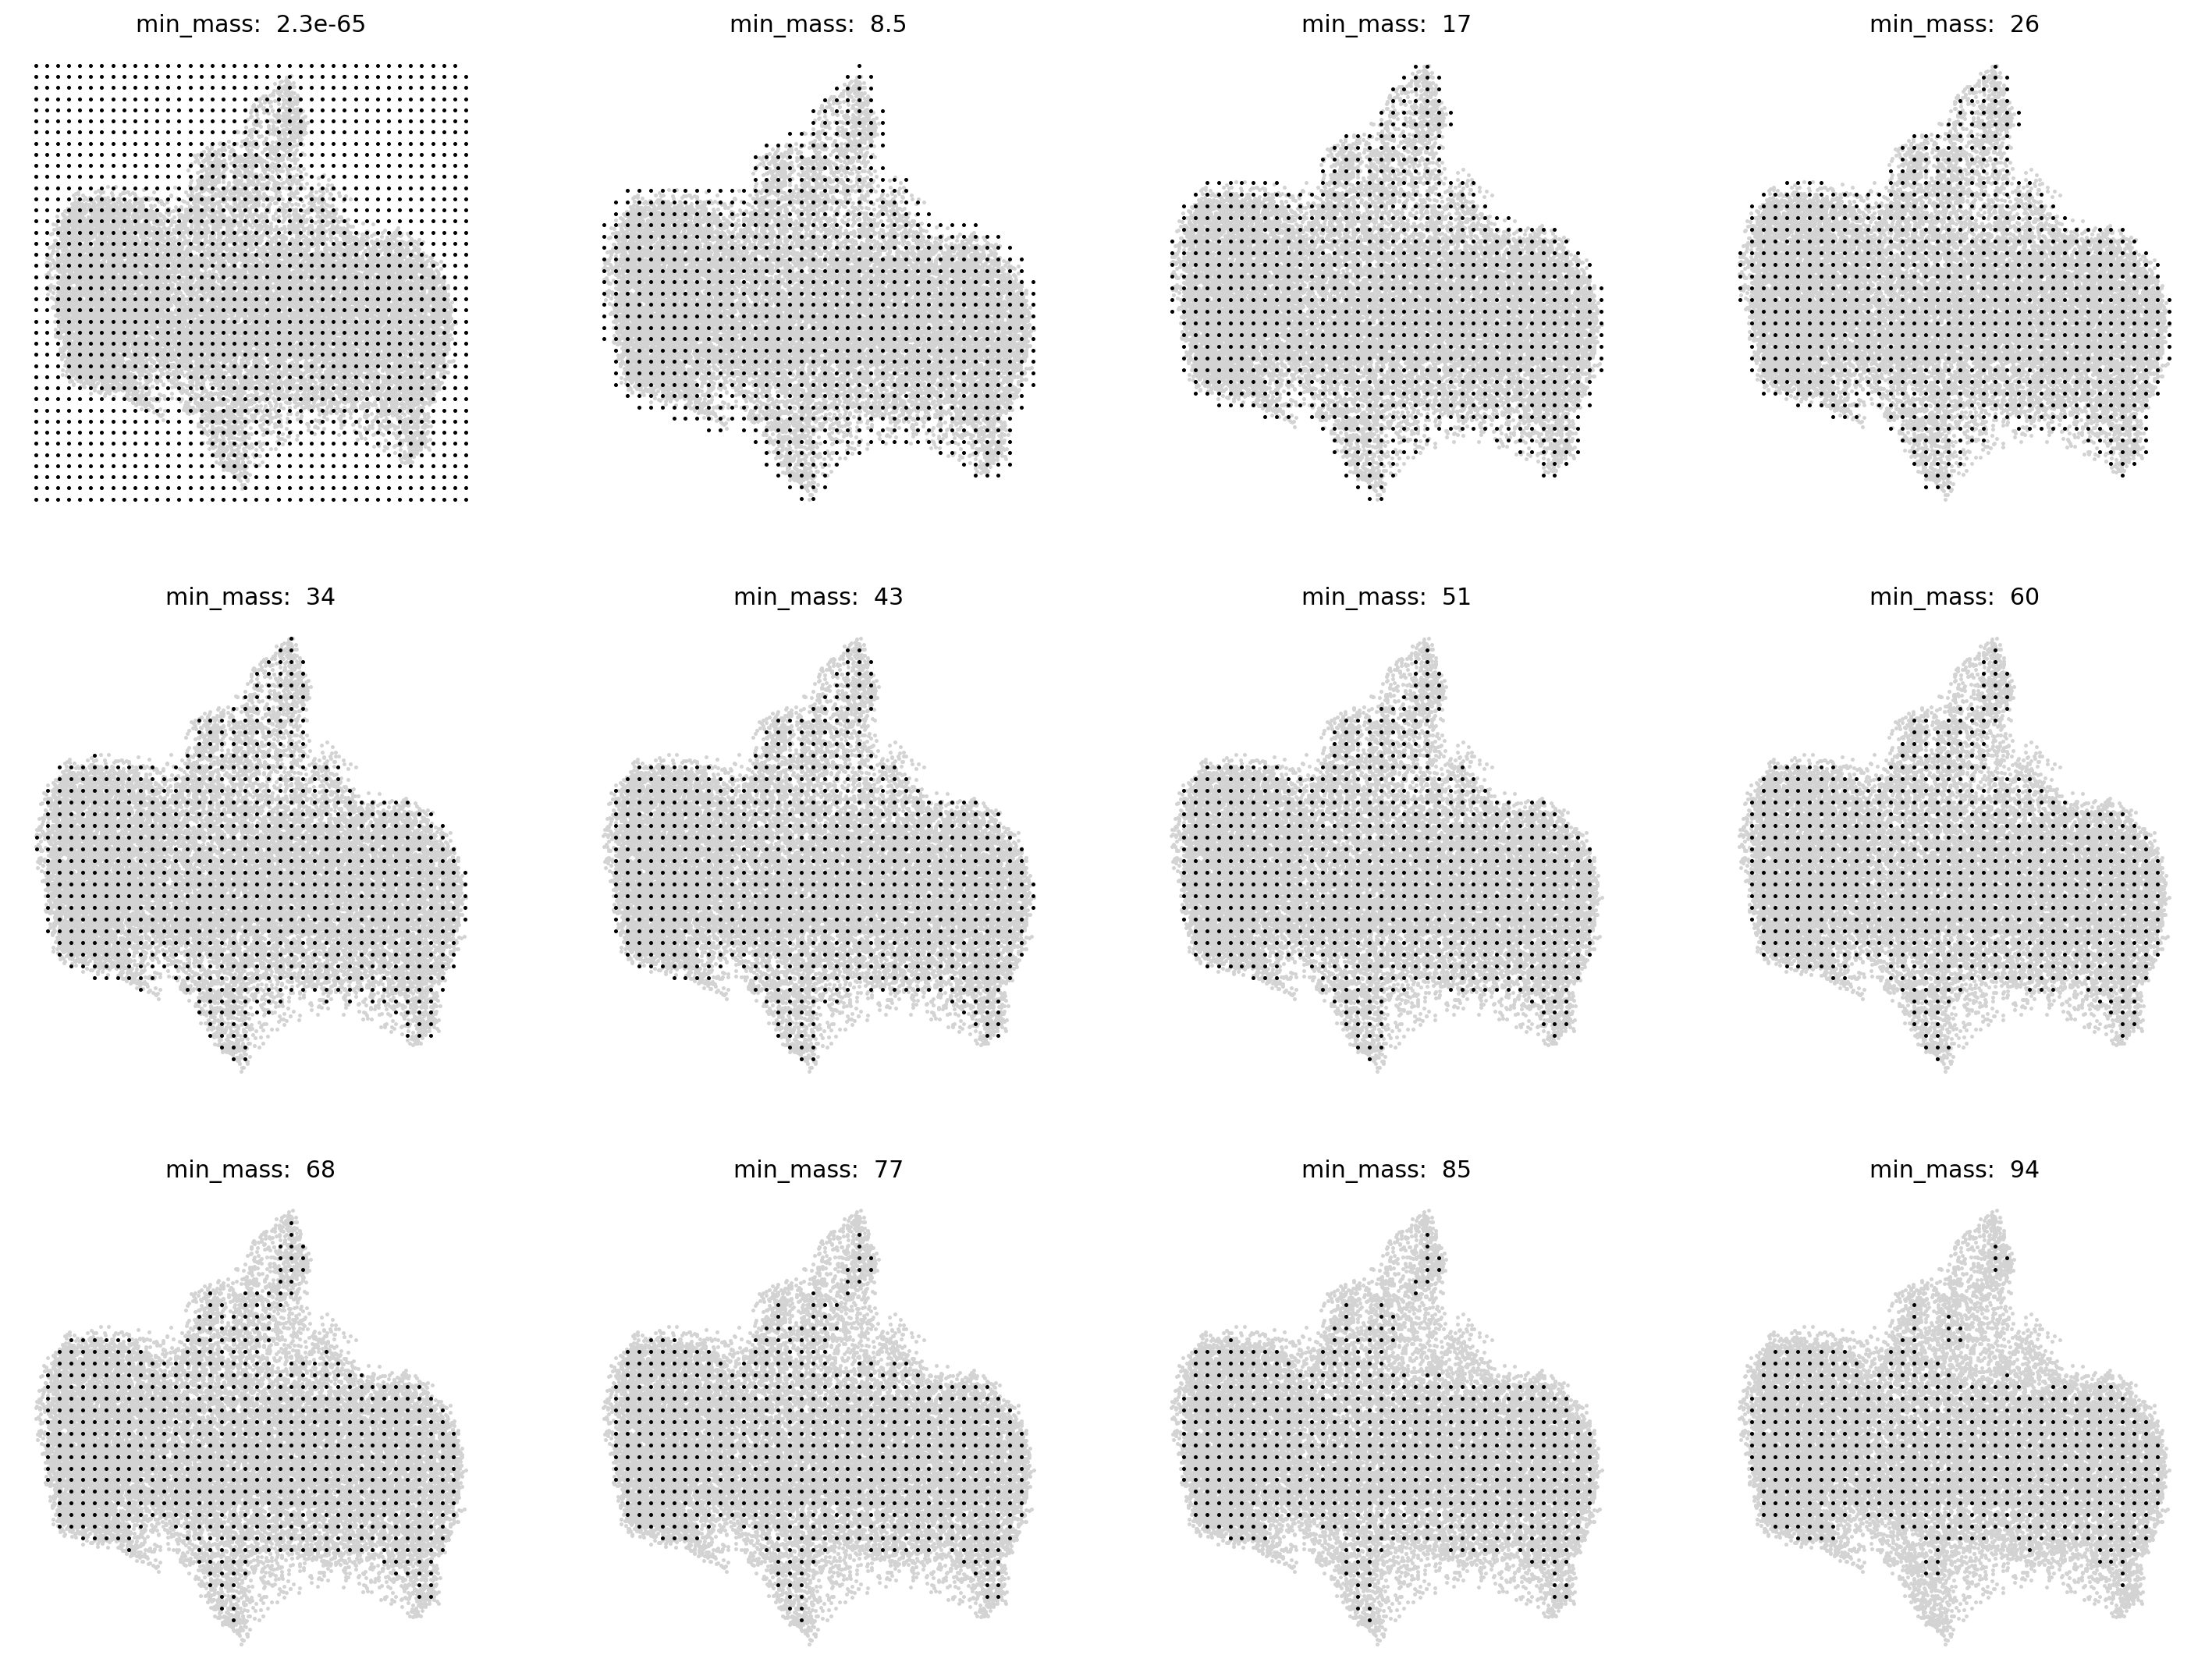

In [ ]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

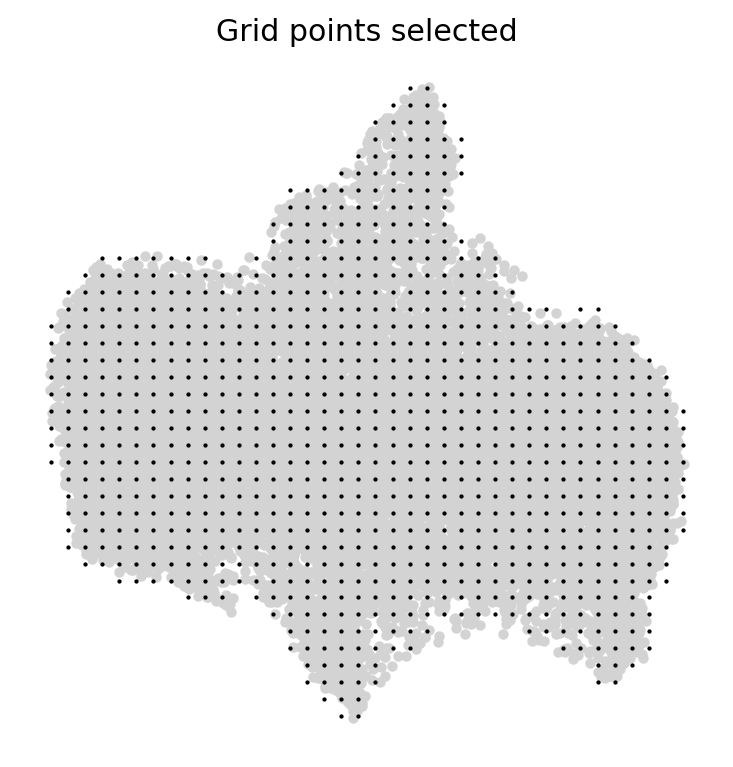

In [ ]:
min_mass = 16
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

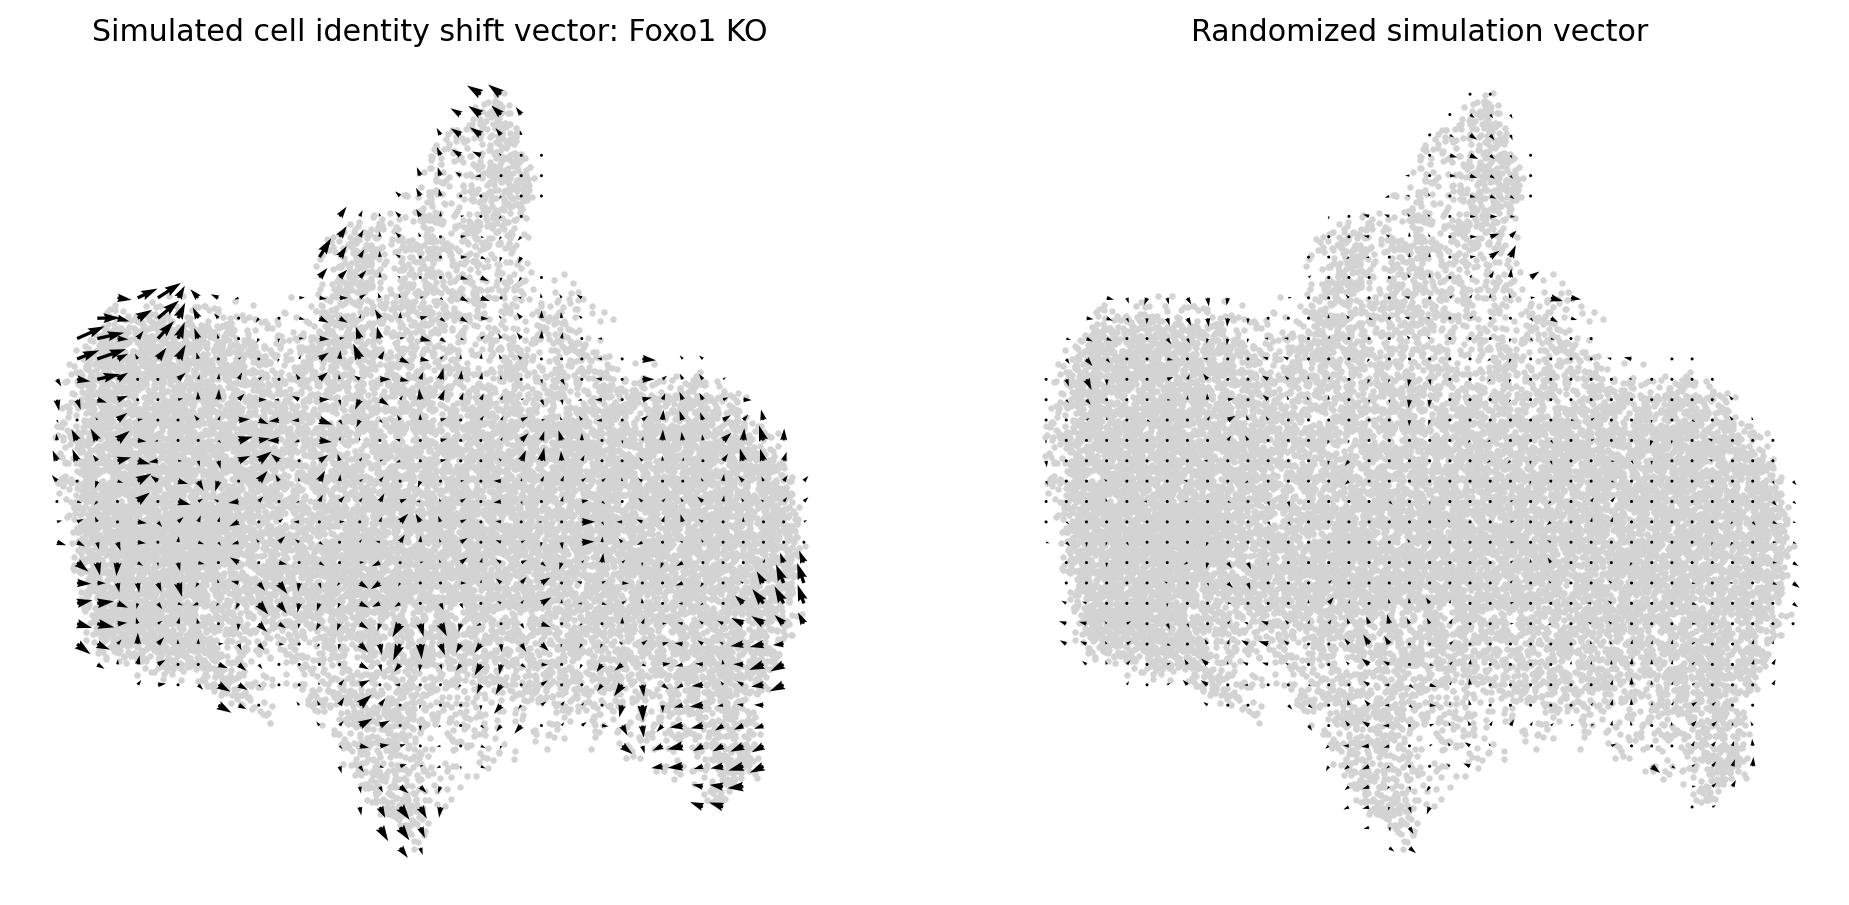

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 1
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

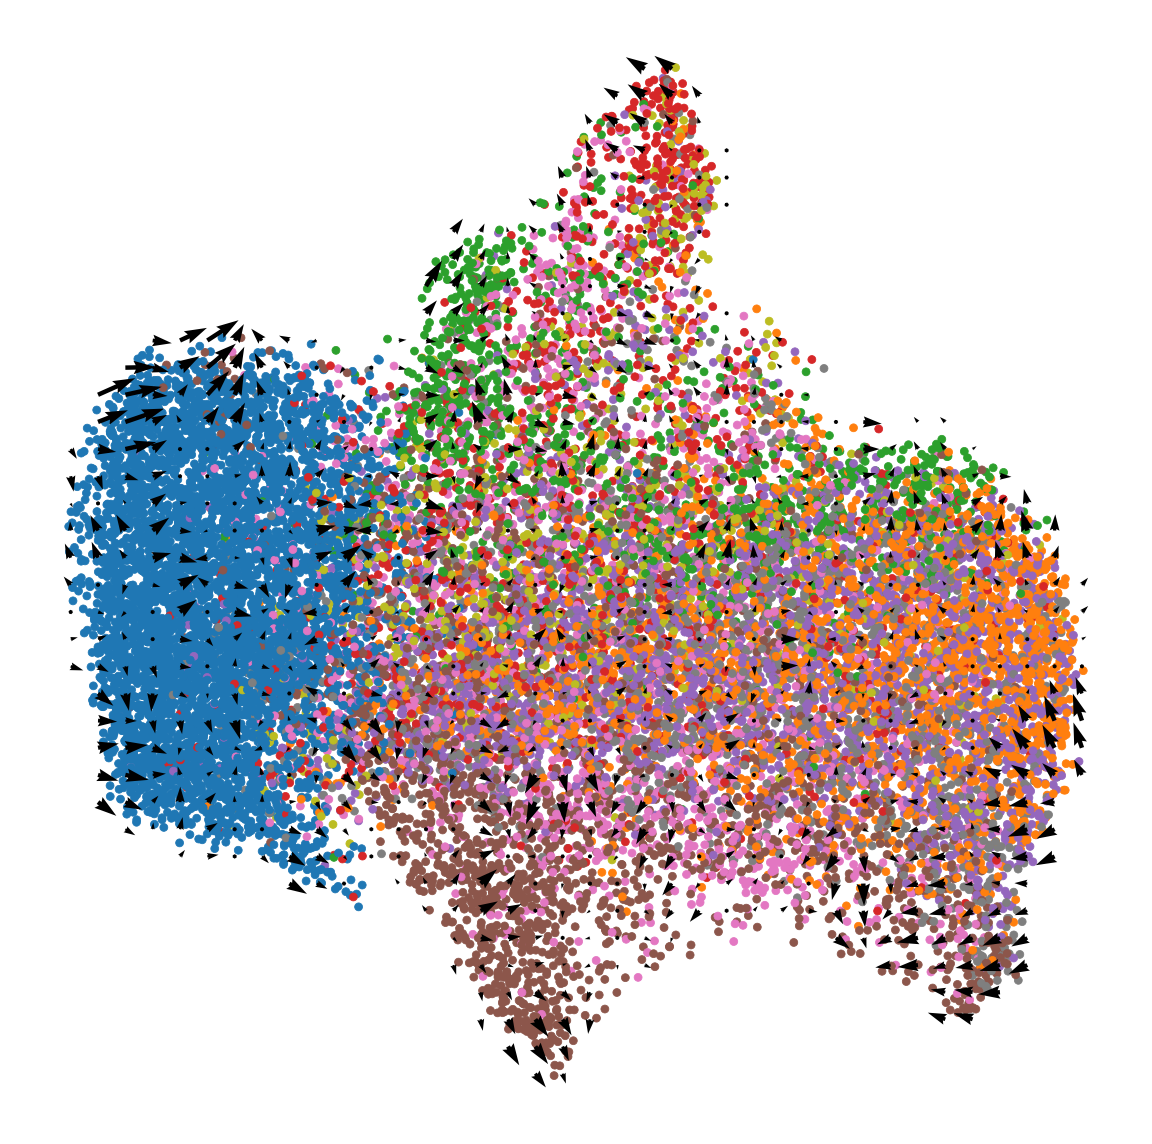

In [ ]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)